# Tarefa 02:

Instituição: Pontifícia Universidade Católica de Minas Gerais

Alunos:

1. Alessandro Augusto Bezerra
1. Vitor Fernando de Souza Rodrigues

Disciplina: Séries Temporais

Docente: Patrícia de Sousa Ilambwetsi

O grupo escolheu a base de dados histórica das transações realizada em uma lista de FIIs. Toda base de transações financeiras da B3 podem ser analisadas através da API da Yahoo [Yfinance](https://pypi.org/project/yfinance/).

# Objetivo

Este trabalho tem como objetivo analisar o comportamento das séries temporais dos preços de fechamento ajustados dos Fundos de Investimento Imobiliário (FIIs) no período de 2014 a 2024. Para a análise, foi selecionado o HGBS11.SA, um fundo que investe especificamente em shopping centers, adquirindo participações nesses empreendimentos e gerando receita através dos aluguéis das lojas. O estudo busca identificar padrões de sazonalidade, tendência e estacionariedade, além de aplicar métodos de suavização para modelagem das séries temporais. A análise pretende oferecer insights sobre o desempenho e a volatilidade do HGBS11.SA, contribuindo para a tomada de decisões de investimento.



## 1. Importação de Bibliotecas

In [1]:
# Para o uso do notebook no google colab, basta apenas instalar a biblioteca abaixo:
# !pip install pymannkendall

Seguem as bibliotecas utilizadas para esta análise.

In [2]:
# Importa as bibliotecas
import numpy as np
import pandas as pd
import yfinance as yf
import plotly.express as px
from matplotlib import pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import pymannkendall as mk
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy.stats import bartlett
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import warnings
warnings.filterwarnings('ignore')

## 2. Bibliotecas de Funções

A API Yfinance possui uma série de funções para extração de dados. Utilizaremos para este escopo apenas a função ***fetch_data*** que realiza o download de uma série de cotações (fetchs), informando as datas de inicio e fim (***start/end***)

In [3]:
def fetch_data(tickers, start, end):
    """Busca os preços ajustados de fechamento para os tickers especificados."""
    data = yf.download(tickers, start=start, end=end)
    return data['Close']

def calculate_returns(prices):
    """Calcula os retornos diários e retorna o DataFrame limpo de valores faltantes."""
    return prices.pct_change().dropna()

def calculate_monthly_returns(returns):
    """Calcula e retorna os retornos mensais a partir dos retornos diários."""
    return returns.resample('M').agg(lambda x: (x + 1).prod() - 1)

def calculate_cumulative_returns(returns):
    """Calcula o retorno acumulado para cada ativo."""
    return (1 + returns).cumprod()

def calculate_annualized_metrics(cumulative_returns):
    """Calcula e retorna o retorno anualizado e o desvio padrão anualizado dos ativos."""
    n_months = len(cumulative_returns)
    annualized_return = cumulative_returns.iloc[-1] ** (12 / n_months) - 1
    sd_annualized = returns.std() * np.sqrt(12)
    return annualized_return, sd_annualized

def plot_cumulative_returns(cumulative_returns):
    """Plota o retorno acumulado de todos os ativos ao longo do tempo."""
    acum = cumulative_returns.reset_index(level=0)
    fig = px.line(acum, x='Date', y=ASSETS, title='Retorno Acumulado dos Ativos')
    fig.show()

def plot_risk_vs_return(annualized_return, sd_annualized):
    """Plota a relação entre risco e retorno anualizado dos ativos."""
    annualized_risk_return = pd.DataFrame({
        'Risco Anualizado': sd_annualized,
        'Retorno Anualizado': annualized_return
    })

    fig = px.scatter(annualized_risk_return,
                     x='Risco Anualizado',
                     y='Retorno Anualizado',
                     text=annualized_risk_return.index,
                     size=[5] * len(annualized_risk_return),
                     title='Risco vs Retorno Anualizado')
    fig.show()

## 3. Séries Temporais

Conforme dito anteriormente, utilizaremos o fundo **HGBS11** em um período de 10 (dez) anos.

In [4]:
# Fundo de Investimentos Imobiliarios (FIIs) escolhido:
ASSETS = ["HGBS11.SA"]
# Data de inicio de coleta
START_DATE = '2014-01-01'
# Data de fim de coleta
END_DATE = '2023-12-31'

prices = fetch_data(ASSETS, START_DATE, END_DATE)
returns = calculate_returns(prices)
cumulative_returns = calculate_cumulative_returns(returns)

[*********************100%%**********************]  1 of 1 completed


Descrição do FII:

**HGBS11.SA (Hedge Brasil Shopping)**
   - **Tipo**: FII de Shoppings.
   - **Descrição**: HGBS11 é um fundo imobiliário que investe em participações em shoppings centers no Brasil. O fundo ganha com a valorização dos imóveis e com o aluguel das lojas desses shoppings. Ele é popular entre investidores
   que buscam exposição ao setor de consumo e varejo.


In [5]:
prices

Date
2014-01-02    159.404816
2014-01-03    162.403015
2014-01-06    162.403015
2014-01-07    162.792786
2014-01-08    162.902725
                 ...    
2023-12-21    224.979996
2023-12-22    227.500000
2023-12-26    226.809998
2023-12-27    228.369995
2023-12-28    230.750000
Name: Close, Length: 2484, dtype: float64

A título de exemplificar a base recolhida, vamos expor em gráfico o comportamento das cotações ao longo do tempo. Mais a frente iremos interpretar este gráfico.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


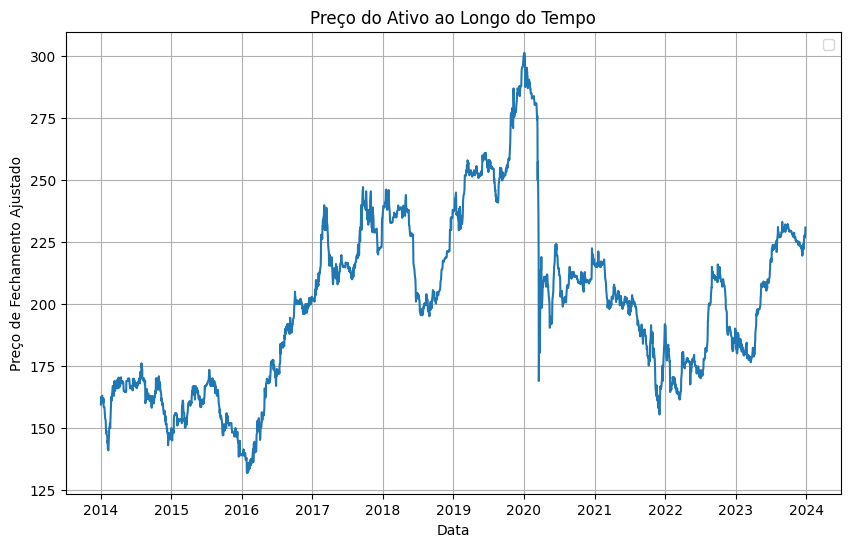

In [6]:
plt.figure(figsize=(10, 6))
plt.plot(prices)
plt.xlabel('Data')
plt.ylabel('Preço de Fechamento Ajustado')
plt.title('Preço do Ativo ao Longo do Tempo')
plt.legend()
plt.grid(True)
plt.show()

## 4. Análise das séries temporais

### 4.1. Classificar a série temporal.

A série temporal em estudo é discreta, pois as observações foram coletadas diariamente, ou seja, em intervalos específicos de tempo.

### 4.2. Determine a estatística descritiva e o boxplot da série. Discorra sobre o resultado.

Estatística descritiva da série:

In [7]:
# Estatísticas descritivas
prices.describe()

count    2484.000000
mean      200.302662
std        34.646673
min       131.921219
25%       169.798351
50%       200.939514
75%       222.836929
max       301.210144
Name: Close, dtype: float64

**HGBS11.SA (Hedge Brasil Shopping)**

Com uma média de `R$ 203,32`, mediana de `R$ 204,71` e um desvio padrão de `R$ 33,91`, o HGBS11 demonstra uma considerável volatilidade. Os preços variaram de `R$ 131,92` a `R$ 301,21`, indicando grandes flutuações ao longo do tempo, o que é comum em FIIs de shoppings, especialmente em períodos de grande instabilidade econômica.


### 4.3. Boxplot emparelhado por mês

In [8]:
# Extraindo o mês e o dia da semana a partir do índice datetime
prices = pd.DataFrame(prices)
prices['Mês'] = prices.index.month_name().str.slice(stop=3)
prices['Dia_da_Semana'] = prices.index.dayofweek
prices

,Close,Mês,Dia_da_Semana
Date,,,
2014-01-02,159.404816,Jan,3
2014-01-03,162.403015,Jan,4
2014-01-06,162.403015,Jan,0
2014-01-07,162.792786,Jan,1
2014-01-08,162.902725,Jan,2
...,...,...,...
2023-12-21,224.979996,Dec,3
2023-12-22,227.500000,Dec,4
2023-12-26,226.809998,Dec,1


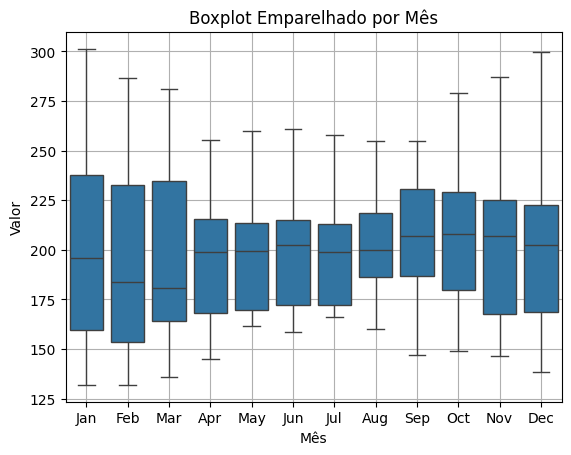

In [9]:
sns.boxplot(x='Mês', y='Close', data=prices)
plt.title('Boxplot Emparelhado por Mês')
plt.suptitle('')  # Remove o título padrão "Boxplot grouped by Mês"
plt.xlabel('Mês')
plt.ylabel('Valor')
plt.grid()
plt.show()

**Análise do Boxplot**:
1. **Dispersão dos Valores:**
   - **Amplitude Interquartil:** A amplitude entre o primeiro e o terceiro quartil (representado pela caixa) varia entre os meses. Isso mostra que a volatilidade dos preços não é uniforme ao longo do ano.
   - **Outliers:** O gráfico parece ter poucos outliers, o que sugere que os valores estão consistentemente dentro de um certo intervalo, com poucas exceções extremas.

2. **Tendências Sazonais:**
   - **Mínimos e Máximos:** Os meses de janeiro, fevereiro, março e dezembro mostram uma maior dispersão, com valores máximos e mínimos mais distantes da mediana, sugerindo maior volatilidade nesses meses. Isso pode estar relacionado a eventos sazonais ou decisões de investidores que impactam o preço nesses períodos.
   - **Mediana:** A mediana (linha dentro da caixa) mostra variações ao longo do ano. Por exemplo, janeiro, fevereiro e março têm medianas mais altas comparadas aos meses de junho a setembro, sugerindo que esses são meses onde o valor do fundo tende a ser mais alta.

3. **Volatilidade:**
   - Os meses de junho a setembro mostram menor dispersão, indicando menor volatilidade. Isso sugere que o fundo tende a ser mais estável durante o meio do ano.
   - Janeiro, fevereiro, março e dezembro, por outro lado, apresentam maior dispersão, o que pode indicar incertezas ou eventos de mercado que causam flutuações maiores nos preços.

**Interpretação Geral**:

- **Estabilidade e Volatilidade:** O fundo HGBS11 parece apresentar uma combinação de períodos de estabilidade (meio do ano) e de maior volatilidade (início e final do ano). Isso pode indicar que o fundo é mais suscetível a variações sazonais ou a eventos de mercado que ocorrem em períodos específicos.
- **Tendência de Preço:** Nos meses de janeiro a março e dezembro, a mediana mais alta sugere uma tendência de aumento no valor do fundo nesses períodos, o que pode ser interessante para investidores que buscam maximizar retornos.
- **Possíveis Implicações:** Investidores podem considerar os meses com menor volatilidade para entradas ou saídas mais seguras, enquanto os períodos de maior volatilidade podem ser oportunidades para traders que procuram aproveitar as flutuações de preço.

Essa análise considera a distribuição dos preços ao longo de 10 anos, o que fornece uma visão robusta sobre o comportamento do fundo ao longo do tempo. Eventos específicos, como crises econômicas, mudanças na legislação ou no mercado imobiliário, também podem ter impactado esses padrões.

### 4.4. Gráfico da série temporal no domínio da frequência

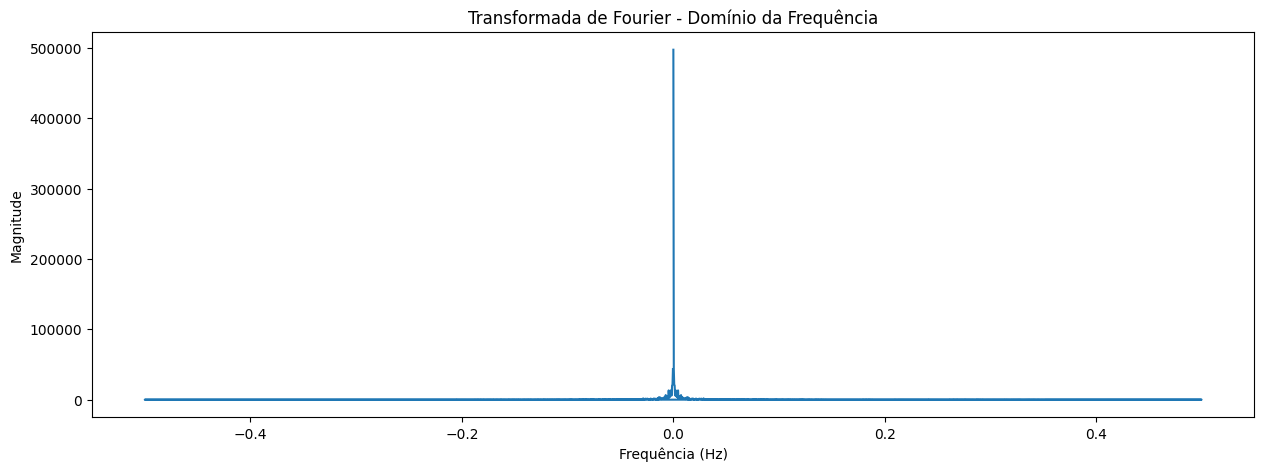

In [10]:
# Aplicar a Transformada Rápida de Fourier (FFT)
serie_frequencia = np.fft.fft(prices.Close)

# Frequências correspondentes
frequencias = np.fft.fftfreq(len(prices.Close))

# Plotar a série no domínio da frequência
plt.figure(figsize=(15, 5))
plt.plot(frequencias, np.abs(serie_frequencia))
plt.title('Transformada de Fourier - Domínio da Frequência')
plt.xlabel('Frequência (Hz)')
plt.ylabel('Magnitude')
plt.show()

A análise da série temporal no domínio da frequência, conforme representada pela Transformada de Fourier no gráfico, revela algumas características importantes:

1. **Pico em Frequência Zero**: O gráfico mostra um pico acentuado em torno da frequência zero. Esse pico sugere que há uma componente constante significativa na série temporal original, o que indica a presença de uma tendência ou um valor médio elevado.

2. **Ausência de Outros Picos Significativos**: Além do pico em zero, o gráfico não apresenta outros picos significativos em frequências diferentes de zero. Isso sugere que a série temporal tem poucas componentes periódicas, ou seja, não há frequências dominantes que representem ciclos repetitivos na série temporal.

3. **Frequências Simétricas**: A simetria ao redor da frequência zero é esperada, uma vez que a transformada de Fourier de uma série temporal real resulta em uma magnitude simétrica no espectro de frequência.

4. **Sinal Estacionário**: A ausência de picos em outras frequências também pode indicar que a série é estacionária em termos de frequência, significando que, além da componente constante, não há variações cíclicas ou sazonais significativas.

O gráfico sugere que a série temporal analisada é dominada por uma componente constante (representada pelo pico em zero), sem variações cíclicas ou periódicas significativas. Se a série original está sendo estudada para identificar padrões cíclicos ou sazonais, o gráfico sugere que esses padrões não estão presentes ou são muito fracos.

### 4.5. Gráfico da série temporal no domínio do tempo

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


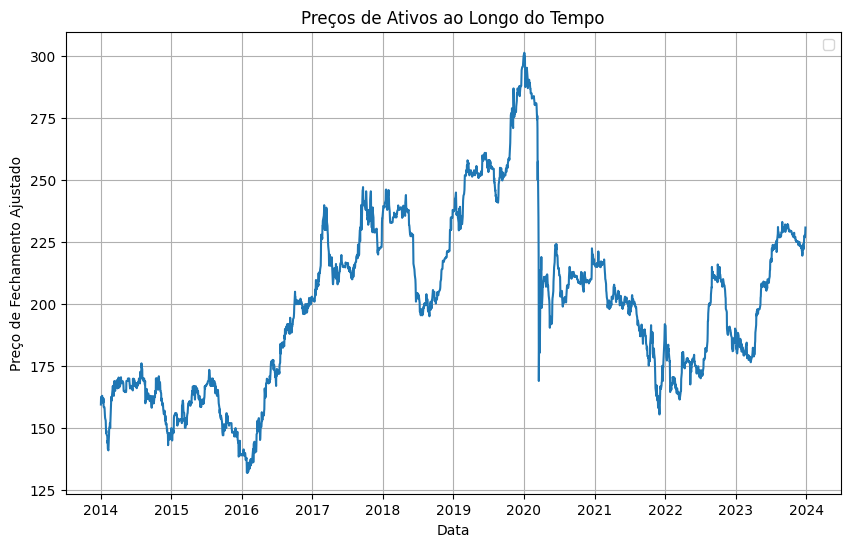

In [11]:
# Plota todos os ativos em um único gráfico
plt.figure(figsize=(10, 6))
plt.plot(prices.index, prices['Close'])
plt.xlabel('Data')
plt.ylabel('Preço de Fechamento Ajustado')
plt.title('Preços de Ativos ao Longo do Tempo')
plt.legend()
plt.grid()
plt.show()

O gráfico apresenta a evolução dos preços de fechamento ajustados de sete fundos imobiliários (FIIs) listados na B3 ao longo do tempo, de 2014 a 2023. Aqui está uma análise detalhada:

* **Tendência:** A série temporal não apresenta uma tendência clara de alta ou baixa ao longo de todo o período. Podemos observar um movimento de alta até o início de 2020, seguido por grande volatilidade (possivelmente COVID-19) e, posteriormente, uma tendência de alta menos pronunciada.

* **Outliers:**  Existem alguns pontos que podem ser considerados outliers, principalmente no período entre 2020 e 2022, onde o gráfico apresenta picos e vales mais acentuados. No entanto, como se trata de um ativo financeiro, essas oscilações podem ser resultado de eventos específicos do mercado e não necessariamente outliers estatísticos.

* **Sazonalidade:** Não é possível identificar um padrão sazonal claro apenas pela observação do gráfico. A sazonalidade se caracteriza por padrões de repetição em períodos específicos, como meses do ano, o que não fica evidente nesse caso.

* **Comportamento:** A série temporal apresenta um comportamento predominantemente **não linear**. Isso significa que não podemos traçar uma linha reta para representar o comportamento dos dados ao longo do tempo.

* Em suma, o **HGBS11.SA** é volátil, com forte oscilação em 2020 e tendência de alta até o final de 2021, seguida de queda.

* As variações no preço de fechamento ajustado podem ser influenciadas por diversos fatores, como desempenho financeiro da empresa, notícias econômicas, eventos globais (como a pandemia de COVID-19 em 2020), entre outros.

* Investidores podem utilizar essas informações para tomar decisões de investimento, analisando o desempenho passado dos ativos.

* É importante lembrar que o gráfico fornece uma visão geral simplificada e não deve ser a única base para decisões financeiras.

### 4.6. Média e desvio padrão dos dados

In [12]:
prices.Close.describe().iloc[[1,2]]

mean    200.302662
std      34.646673
Name: Close, dtype: float64

A série temporal do HGBS11 **não parece ser estacionária**. Uma série estacionária exibe média e variância constantes ao longo do tempo. No gráfico, podemos observar o seguinte:

* **Tendência:** Existe uma clara tendência de alta no preço do ativo ao longo do período, principalmente entre 2016 e 2020. Isso indica que a média não é constante ao longo do tempo.
* **Volatilidade:** A volatilidade parece variar ao longo do tempo. Por exemplo, o período em torno de 2020 apresenta uma volatilidade maior em comparação com outros períodos. Isso sugere que a variância não é constante.

**Média:**

Embora a média calculada seja 200.30, visualmente,  a média dos preços se altera ao longo do tempo,  principalmente devido à tendência de alta. A média calculada representa a média de todo o período, mas não reflete a média em diferentes pontos no tempo.

**Variância:**

A variância, cujo valor é 34.64,  mede a dispersão dos dados em torno da média. Como mencionado, a volatilidade (e, portanto, a variância) parece mudar ao longo do tempo, indicando não estacionariedade.

Em resumo, a análise visual do gráfico e a presença de tendência e volatilidade variável sugerem que a série temporal do HGBS11 não é estacionária. No entanto, testes estatísticos formais são necessários para confirmar essa hipótese.

### 4.7. Decomposição da Série temporal

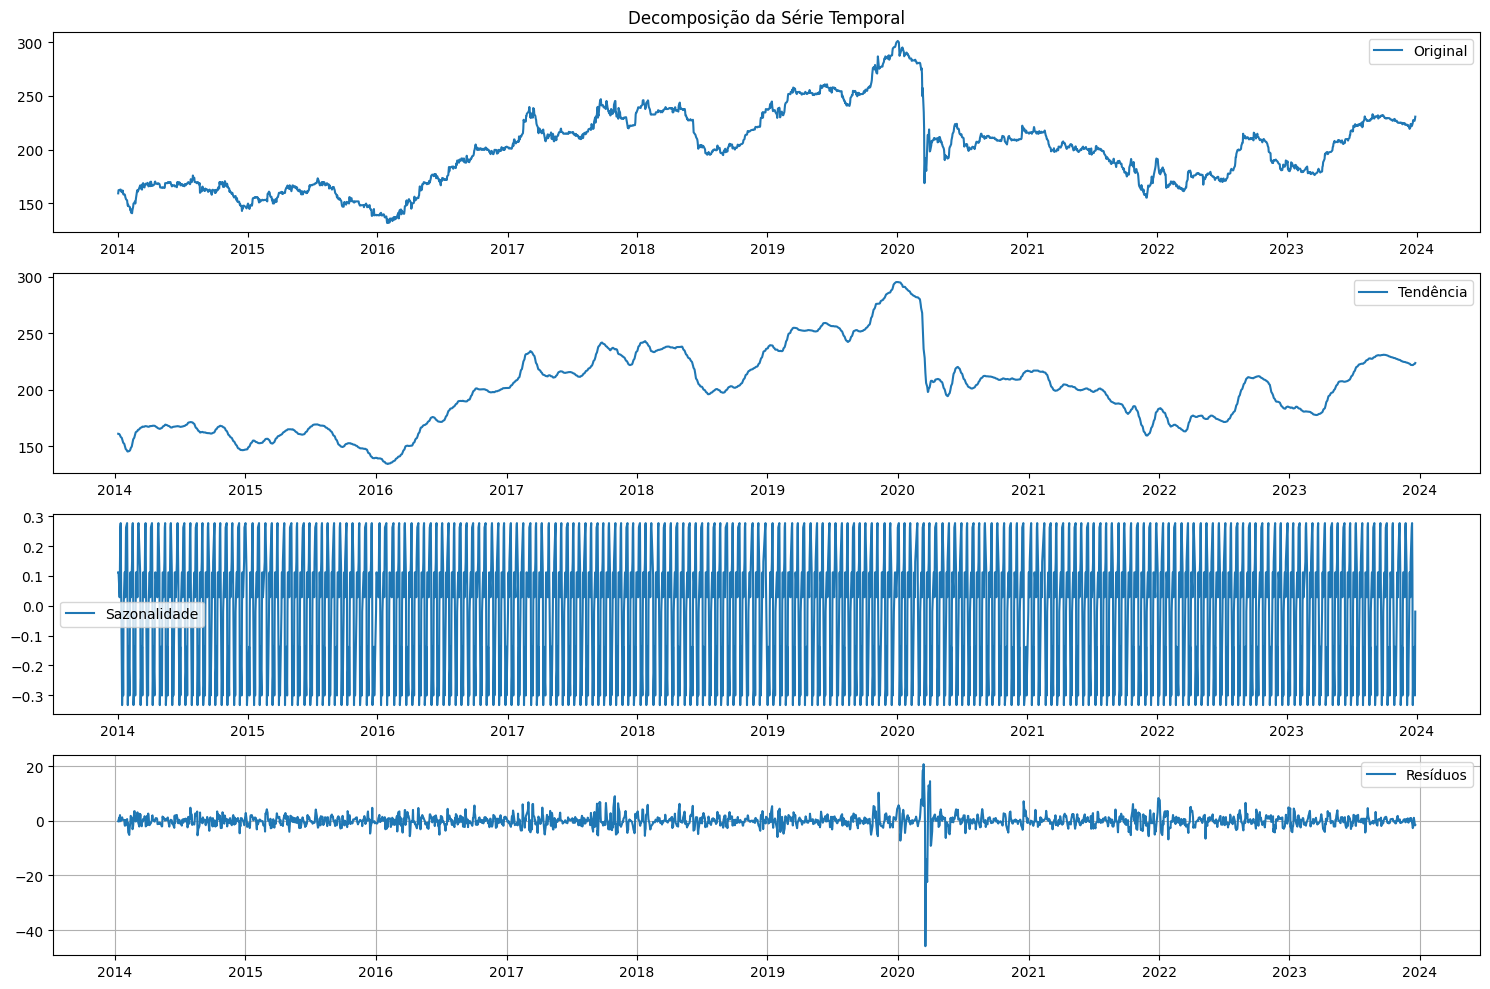

In [13]:
# Decomposição aditiva
decomposition = seasonal_decompose(prices.Close, model='additive', period=12) #model= 'multiplicative' ou 'additive'

# Plotar os componentes
plt.figure(figsize=(15, 10))

plt.subplot(411)
plt.title('Decomposição da Série Temporal')
plt.plot(prices.Close, label='Original')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(decomposition.trend, label='Tendência')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(decomposition.seasonal, label='Sazonalidade')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(decomposition.resid, label='Resíduos')
plt.legend(loc='best')

plt.tight_layout()
plt.grid()
plt.show()

**Os gráficos apresentados oferecem uma decomposição da série temporal do Fundo Imobiliário HGBS11.SA em suas componentes principais: original, tendência, sazonalidade e resíduos**

* **Série Original:**
A série original apresenta uma tendência de crescimento geral ao longo do período analisado, indicando um aumento gradual no valor das cotas do fundo. Essa tendência positiva sugere que, no longo prazo, o investimento no HGBS11.SA tem sido lucrativo.
A série também apresenta uma considerável volatilidade, com oscilações significativas em torno da tendência de crescimento. Essa volatilidade é característica do mercado de fundos imobiliários e pode ser atribuída a diversos fatores, como variações nas taxas de juros, condições do mercado imobiliário, e eventos específicos que impactam o setor.

* **Tendência:**
O componente de tendência captura o movimento geral de crescimento do fundo ao longo do tempo, eliminando as flutuações de curto prazo.
A linha da tendência é mais suave que a série original, evidenciando a tendência de longo prazo do fundo.

* **Sazonalidade:**
O componente sazonal mostra um padrão repetitivo de flutuações ao longo do tempo, indicando que o fundo pode apresentar um desempenho melhor ou pior em determinados períodos do ano.
A amplitude das flutuações sazonais varia ao longo do tempo, sugerindo que a intensidade do efeito sazonal pode mudar ao longo dos anos.

* **Resíduos:**
Ruído: O componente dos resíduos representa a parte da série que não pode ser explicada pela tendência e pela sazonalidade. Ela é composta por flutuações aleatórias e imprevisíveis.
A volatilidade dos resíduos pode variar ao longo do tempo, indicando que a incerteza sobre o futuro do fundo pode mudar.

A decomposição da série temporal do HGBS11.SA em suas componentes principais fornece uma visão mais clara sobre o comportamento do fundo ao longo do tempo. A presença de sazonalidade e a volatilidade dos resíduos sugerem que o desempenho do fundo é influenciado por uma combinação de fatores de longo prazo, sazonais e aleatórios.

### 4.8. Extração da componente sazonal

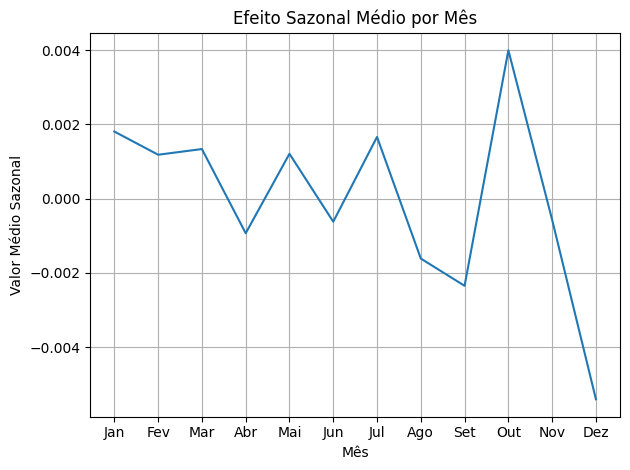

In [14]:
decomposition = seasonal_decompose(prices.Close.dropna(), model='additive', period=12) #model= 'multiplicative' ou 'additive'

# Extração da componente sazonal
seasonal = decomposition.seasonal

# Agrupando por mês para visualizar o efeito sazonal médio de cada mês
seasonal_monthly = seasonal.groupby(seasonal.index.month).mean()

# Plotando o efeito sazonal por mês
plt.plot(seasonal_monthly)
plt.title('Efeito Sazonal Médio por Mês')
plt.xlabel('Mês')
plt.ylabel('Valor Médio Sazonal')
plt.xticks(range(1, 13), ['Jan', 'Fev', 'Mar', 'Abr', 'Mai', 'Jun', 'Jul', 'Ago', 'Set', 'Out', 'Nov', 'Dez'], rotation=0)

plt.grid()
plt.tight_layout()
plt.show()

**Análises de Sazonalidade Valor Médio Mensal**

* **HGBS11.SA:**
 * Picos positivos de janeiro a fevereiro, maio, julho e outubro.
 * Vales negativos em abril, junho, agosto, setembro e dezembro.
 * A amplitude da variação fica entre cerca de -0.005 e 0.004.

### 4.9. Verificar estacionariedade (média e variância constante)

#### 4.9.1. Correlograma

Pontos fora da faixa de confiança pode indicar autocorrelação temporal da série positiva, ou seja, uma tendência significativa

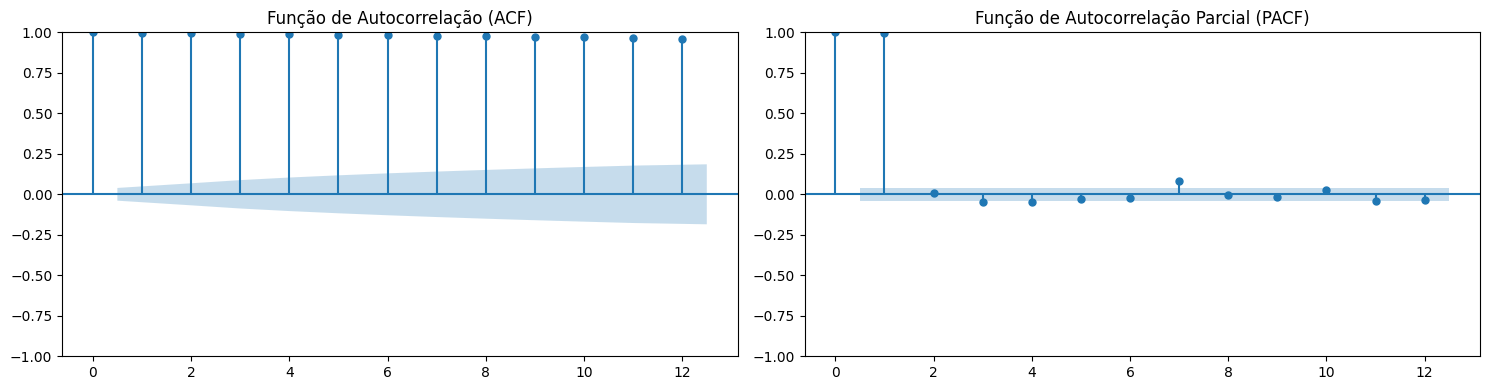

In [15]:
# Plotando a função de autocorrelação e autocorrelação parcial em subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))

# Autocorrelação
plot_acf(prices.Close, lags=12, ax=ax1)
ax1.set_title('Função de Autocorrelação (ACF)')

# Autocorrelação Parcial
plot_pacf(prices.Close, lags=12, ax=ax2)
ax2.set_title('Função de Autocorrelação Parcial (PACF)')

plt.tight_layout()
plt.show()

Para verificar a estacionariedade de uma série temporal com base na autocorrelação (ACF) e autocorrelação parcial (PACF), podemos considerar os seguintes pontos ao analisar os gráficos da imagens seguindo a abordagem para avaliar a estacionariedade e correlação:

**Análises dos Resultados**

* **Autocorrelação (ACF):**
 * No eixo da autocorrelação, séries estacionárias geralmente apresentam um decaimento rápido na autocorrelação conforme o número de lags aumenta. Se as barras da ACF decaem rapidamente, a série provavelmente é estacionária. Caso contrário, a série pode não ser estacionária.
 * Nos gráficos da ACF (esquerda), há uma autocorrelação positiva alta e persistente em vários lags, o que pode indicar que as séries não são estacionárias. Esse padrão sugere que a média e/ou variância podem não ser constantes.

* **Autocorrelação Parcial (PACF):**
 * No PACF (à direita), observamos um decaimento mais rápido. Para uma série estacionária, o gráfico de PACF geralmente mostra correlações significativas apenas nos primeiros lags, com as correlações subsequentes caindo para valores próximos de zero.
 * Para o HGBS11.SA, o PACF mostra valores significativos apenas nos primeiros lags (como em lag 1), com um rápido decaimento. Isso pode ser um indício de que as séries podem ser transformadas para estacionariedade (talvez por diferenciação), mas inicialmente não parecem estacionárias.

**Considerações sobre a estacionariedade:**

 * **Média constante:** Como a ACF não decai rapidamente, parece que há uma correlação significativa em vários lags. Isso indica que a média pode não ser constante, sugerindo uma tendência ou sazonalidade na série.
 * **Variância constante:** Para séries estacionárias, a variância deve ser constante ao longo do tempo. Embora a ACF não forneça uma verificação direta de variância, se a série for estacionária após uma transformação, espera-se que a variância também seja constante.

* **Conclusão**
 * Com base nos gráficos de ACF e PACF, a série HGBS11.SA parece não ser estacionárias inicialmente. No entanto, a aplicação de uma transformação, como diferenciação, pode ajudar a torná-las estacionárias.

 * O comportamento da PACF sugere que há uma possível estrutura autoregressiva (AR(1)), com o primeiro lag sendo o mais relevante e os demais próximos de zero.
Para tornar as séries estacionárias, seria recomendável aplicar uma transformação, como a diferenciação de primeira ordem (diferenças entre valores consecutivos), para remover tendências e alcançar uma média constante ao longo do tempo.

#### 4.9.2. Teste de Dickey-Fuller Aumentado para verificar estacionariedade

H<sub>0</sub>: a series não é estacionária

H<sub>1</sub>: a series é estacionária.

pvalor< alpha (nível de significância geralmente 5%) = rejeita-se H<sub>0</sub>

In [16]:
# Inicializando um dicionário para armazenar os resultados
results_dict = {
    'Teste Estatístico': [],
    'Valor-p': [],
    'Valor Crítico 1%': [],
    'Valor Crítico 5%': [],
    'Valor Crítico 10%': [],
    'Estacionariedade': []
}

# Iterando sobre as colunas do dataframe prices

result = adfuller(prices.Close)

# Armazenando os resultados no dicionário
results_dict['Teste Estatístico'].append(result[0])
results_dict['Valor-p'].append(result[1])
results_dict['Valor Crítico 1%'].append(result[4]['1%'])
results_dict['Valor Crítico 5%'].append(result[4]['5%'])
results_dict['Valor Crítico 10%'].append(result[4]['10%'])

# Interpretação do resultado
if result[1] < 0.05:
    results_dict['Estacionariedade'].append('Estacionária (Rejeita H0)')
else:
    results_dict['Estacionariedade'].append('Não Estacionária (Não rejeita H0)')

# Criando o dataframe com os resultados
results_df = pd.DataFrame(results_dict)

# Exibindo o dataframe resultante
print('Dickey-Fuller Aumentado')
results_df.T

Dickey-Fuller Aumentado


,0
Teste Estatístico,-1.936001
Valor-p,0.315319
Valor Crítico 1%,-3.432993
Valor Crítico 5%,-2.862708
Valor Crítico 10%,-2.567392
Estacionariedade,Não Estacionária (Não rejeita H0)


O teste de Dickey-Fuller Aumentado (ADF) é utilizado para verificar a estacionariedade de uma série temporal, ou seja, para determinar se uma série temporal possui uma tendência ou uma estrutura que muda ao longo do tempo. A hipótese nula (H<sub>0</sub>) do teste é que a série temporal possui uma raiz unitária, o que implica que a série não é estacionária (ou seja, tem alguma tendência ou padrão que não é constante ao longo do tempo).

**Análise dos Resultados**

* Considere as seguintes variáveis para nossa análise:

  * **Teste Estatístico:** Este é o valor calculado do teste ADF.

  * **Valor-p:** Este é o valor-p associado ao teste. Um valor-p menor que um nível de significância previamente determinado (comumente 0,05 ou 5%) sugere que podemos rejeitar a hipótese nula (H<sub>0</sub>) de que a série é não estacionária.

  * **Valores Críticos:** Estes são os valores críticos para diferentes níveis de significância (1%, 5%, 10%). Se o valor do teste estatístico for menor (mais negativo) que o valor crítico, rejeitamos a hipótese nula de que a série é não estacionária.

  * **Estacionariedade:** Esta coluna indica se a série é estacionária ou não com base nos resultados do teste.

* Para o **HGBS11.SA:**
 * **Teste Estatístico:** -1.936
 * **Valor-p:** 0.3153
 * **Conclusão:** O valor-p é maior que 0,05 e o teste estatístico não é menor que os valores críticos de 1%, 5% ou 10%. Portanto, não rejeitamos a hipótese nula, indicando que a série **não** é estacionária.

#### 4.9.3. Teste de Mann Kendall para verificar Tendência

H<sub>0</sub>: Nao existe tendência significativa

H<sub>1</sub>: Existe tendência significativa

pvalor < nível de significância de 5% rejeita H<sub>0</sub>

In [17]:
# Inicializando um dicionário para armazenar os resultados
results_dict = {
    'Tipo de Tendência': [],
    'Valor-p': [],
    'Teste Estatístico': [],
    'Tendência Significativa': []
}

# Iterando sobre as colunas do dataframe prices

result = mk.original_test(prices.Close)

# Armazenando os resultados no dicionário
results_dict['Tipo de Tendência'].append(result.trend)
results_dict['Valor-p'].append(result.p)
results_dict['Teste Estatístico'].append(result.z)

# Interpretação do resultado
if result.p < 0.05:
    results_dict['Tendência Significativa'].append('Sim (Rejeita H0)')
else:
    results_dict['Tendência Significativa'].append('Não (Não rejeita H0)')

# Criando o dataframe com os resultados
results_df = pd.DataFrame(results_dict)

# Exibindo o dataframe resultante
print('Teste de Mann Kendall')
results_df.T

Teste de Mann Kendall


,0
Tipo de Tendência,increasing
Valor-p,0.0
Teste Estatístico,19.272406
Tendência Significativa,Sim (Rejeita H0)


O teste de Mann-Kendall é um teste estatístico não paramétrico utilizado para identificar a presença de uma tendência monotônica em uma série temporal. Ele avalia se os dados mostram uma tendência de aumento, diminuição ou se não há uma tendência significativa ao longo do tempo.

**Análise dos Resultados**

* **Tipo de Tendência:**
HGBS11.SA apresenta uma tendência aumentando ("increasing"). Isso significa que os valores desse ativo têm mostrado um crescimento consistente ao longo do tempo.

* **Valor-p:**
O valor-p é 0.0. Um valor-p tão baixo indica que a probabilidade de que a tendência observada tenha ocorrido por acaso é extremamente pequena. Isso significa que as tendências detectadas são estatisticamente significativas.

* **Teste Estatístico:**
O teste estatístico representa a magnitude da tendência. Valores positivos indicam uma tendência de alta, enquanto valores negativos indicam uma tendência de baixa. Neste caso, HGBS11.SA possui uma tendência de alta (19.27)

* **Tendência Significativa:**
A tendência foi considerada significativa. Isso é indicado pela rejeição da hipótese nula (H<sub>0</sub>), que assume que não há tendência na série temporal. A rejeição de H<sub>0</sub> sugere que as tendências observadas são estatisticamente robustas.

* Em conclusão, HGBS11.SA está mostrando uma tendência de alta significativa, o que pode indicar que seus preços estão em ascensão ao longo do período analisado.

#### 4.9.4. Teste de Ljungbox para verificar autocorrelação sazonal

In [18]:
# Inicializando um dicionário para armazenar os resultados
results_dict = {
    'Teste Estatístico Ljung-Box': [],
    'Valor-p Ljung-Box': [],
    'Autocorrelação Sazonal Significativa': []
}

# Iterando sobre as colunas do dataframe prices

# Decomposição STL
stl = seasonal_decompose(prices.Close, period=12)  # Ajuste o 'period' conforme necessário

# Teste de Ljung-Box nos resíduos
residuals = stl.resid.dropna()
ljung_box_test = acorr_ljungbox(residuals, lags=[12], return_df=True)

# Armazenando os resultados no dicionário
lb_stat = ljung_box_test['lb_stat'].values[0]
lb_pvalue = ljung_box_test['lb_pvalue'].values[0]

results_dict['Teste Estatístico Ljung-Box'].append(lb_stat)
results_dict['Valor-p Ljung-Box'].append(lb_pvalue)

# Interpretação do resultado
if lb_pvalue < 0.05:
    results_dict['Autocorrelação Sazonal Significativa'].append('Sim (Rejeita H0)')
else:
    results_dict['Autocorrelação Sazonal Significativa'].append('Não (Não rejeita H0)')

# Criando o dataframe com os resultados
results_df = pd.DataFrame(results_dict)

# Exibindo o dataframe resultante
print('Teste de Ljungbox')
results_df.T


Teste de Ljungbox


,0
Teste Estatístico Ljung-Box,1914.979733
Valor-p Ljung-Box,0.0
Autocorrelação Sazonal Significativa,Sim (Rejeita H0)


O Teste de Ljung-Box é uma ferramenta estatística utilizada para verificar a presença de autocorrelação em uma série temporal, ou seja, para testar se os valores de uma série são independentes ao longo do tempo. Especificamente, ele avalia se há correlação significativa entre observações em diferentes lags (intervalos de tempo).

**Análise dos Resultados**

* **Teste Estatístico Ljung-Box:**
O valor apresentado para o teste estatístico (1914.98) é elevado, indicando que há uma forte evidência contra a hipótese nula (H<sub>0</sub>) de que não há autocorrelação nas séries temporais dos respectivos ativos. Os valores da estatística do teste são significativamente altos.

* **Valor-p:**
O p-valor é 0.0, o que significa que a probabilidade de observarmos um valor do teste tão extremo quanto o obtido (ou mais extremo) sob a hipótese nula é praticamente zero.
Com um valor-p de 0.0, rejeitamos a hipótese nula (H<sub>0</sub>). A hipótese nula, nesse contexto, é a de que não há autocorrelação significativa nas séries temporais.

* **Conclusão sobre a Autocorrelação Sazonal:**
Dado que a hipótese nula foi rejeitada, concluímos que existe autocorrelação sazonal significativa.

**Implicações**

* **Autocorrelação Significativa:**
A presença de autocorrelação significa que os valores passados da série têm influência sobre os valores futuros. Isso pode indicar a presença de padrões ou ciclos que se repetem ao longo do tempo.

* **Modelagem:**
Para modelar essa série temporal de maneira eficaz, seria necessário considerar métodos que possam capturar essa autocorrelação, como modelos ARIMA (AutoRegressive Integrated Moving Average) ou outros modelos que incorporem sazonalidade e dependência temporal.

* **Previsão:**
A presença de autocorrelação pode melhorar a precisão das previsões, pois modelos que levam em conta a dependência temporal podem fazer previsões mais assertivas ao identificar padrões históricos que se repetem.

**Conclusão**
* O resultado do Teste de Ljung-Box indica que a série temporal apresenta autocorrelação significativa nos resíduos. Isso sugere que essa série não é aleatória e que há um padrão temporal que deve ser considerado em qualquer análise subsequente, seja para previsão ou para entender a dinâmica subjacente dos preços.
* Além disso, também significa que o modelo utilizado para gerar as previsões para esse ativo provavelmente não está capturando toda a informação presente nos dados, e que existem padrões de dependência temporal nos resíduos que não foram explicados pelo modelo.

Em resumo, os resultados do Teste de Ljung-Box indicam a necessidade de revisão e ajuste dos modelos utilizados para prever o comportamento do ativo financeiro, a fim de obter previsões mais precisas e confiáveis.

#### 4.9.5. Teste para avaliar homogeneidade de Variância

In [19]:
# Inicializando um dicionário para armazenar os resultados
results_dict = {
    'Estatística de Bartlett': [],
    'Valor-p Bartlett': [],
    'Variâncias Diferentes': []
}

# Separando a série em 2 grupos
metade = int(prices.Close.shape[0] / 2)
serie1 = prices.Close[:metade]
serie2 = prices.Close[metade+1:]

# Realizando o teste de Bartlett
estatistica, p_valor = bartlett(serie1, serie2)

# Armazenando os resultados no dicionário
results_dict['Estatística de Bartlett'].append(estatistica)
results_dict['Valor-p Bartlett'].append(p_valor)

# Interpretação do resultado
if p_valor < 0.05:
    results_dict['Variâncias Diferentes'].append('Variâncias muito diferentes (Rejeita H0)')
else:
    results_dict['Variâncias Diferentes'].append('Não é possível afirmar que as variâncias são diferentes (Não rejeita H0)')

# Criando o dataframe com os resultados
results_df = pd.DataFrame(results_dict)

# Exibindo o dataframe resultante
print('Avaliação da homogeneidade da variância')
results_df.T


Avaliação da homogeneidade da variância


,0
Estatística de Bartlett,0.478398
Valor-p Bartlett,0.489149
Variâncias Diferentes,Não é possível afirmar que as variâncias são d...


O Teste de Bartlett é utilizado para verificar a homogeneidade de variâncias entre diferentes grupos ou amostras. O teste avalia a hipótese nula (H<sub>0</sub>) de que todas as variâncias são iguais contra a alternativa de que pelo menos uma variância é diferente.

Vamos analisar os resultados em detalhes:

1. **Estatística de Bartlett: 0.47839782131382497**
   - Esse valor representa a estatística de teste de Bartlett. Ele é utilizado para calcular o valor-p correspondente, mas por si só, não fornece uma interpretação direta sem o contexto do valor-p.

2. **Valor-p Bartlett: 0.4891489353639674**
   - O valor-p é a probabilidade de observarmos uma estatística de teste tão extrema quanto, ou mais extrema que, a estatística observada sob a hipótese nula. Um valor-p elevado indica que há pouca evidência contra a hipótese nula.
   - Neste caso, o valor-p é 0.4891, que é muito maior que o nível de significância típico (por exemplo, 0.05).

3. **Conclusão:**
   - **"Não é possível afirmar que as variâncias são diferentes (Não rejeita H<sub>0</sub>)"**: Com base no valor-p elevado, não há evidências suficientes para rejeitar a hipótese nula de que as variâncias entre os grupos são iguais. Isso significa que, para o ativo financeiro HGBS11.SA, não podemos afirmar que as variâncias sejam significativamente diferentes entre os períodos ou grupos analisados.
  
Em resumo, o teste de Bartlett sugere que as variâncias dos diferentes grupos (possivelmente diferentes períodos) da série temporal de HGBS11.SA não são significativamente diferentes, indicando uma relativa homogeneidade na volatilidade do ativo ao longo do tempo.


### 4.10. Método da diferenciação para transformar a série em estacionária

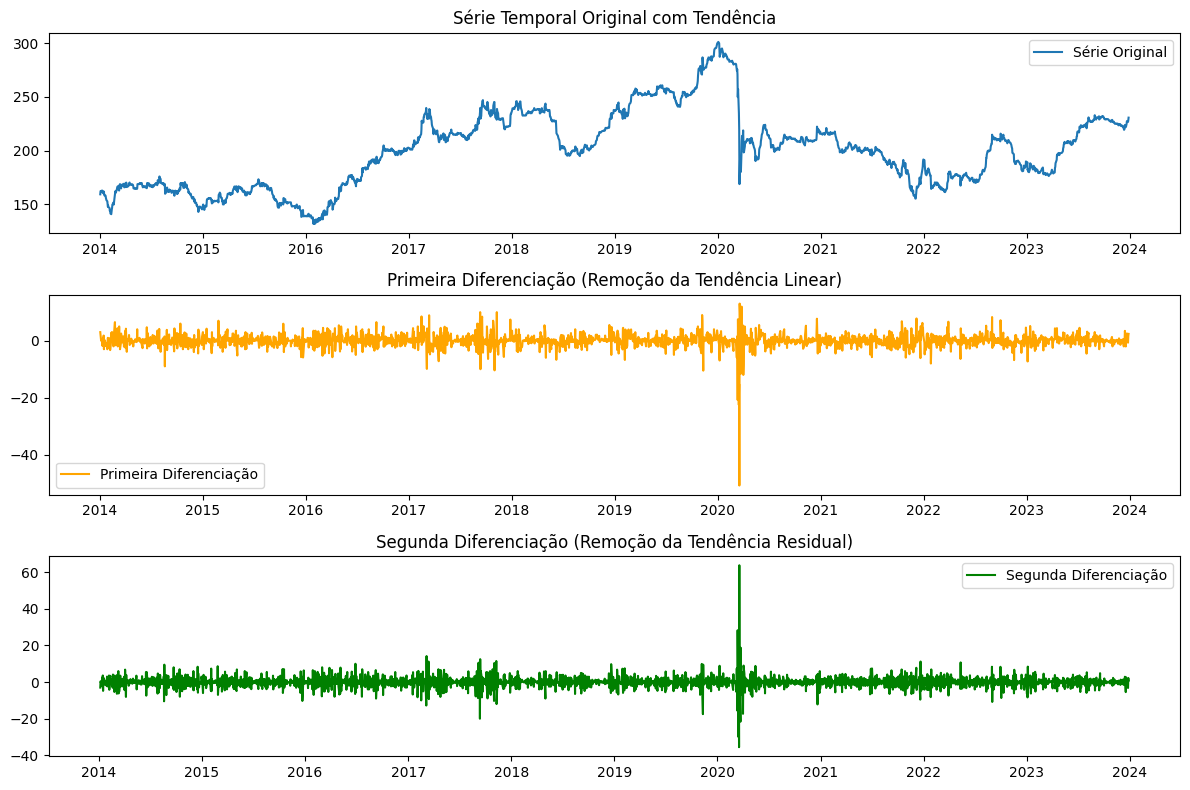

In [20]:
# Aplicar a primeira diferenciação
prices['Close' + '_Primeira_Diferenca'] = prices['Close'].diff()

# Aplicar a segunda diferenciação
prices['Close' + '_Segunda_Diferenca'] = prices['Close' + '_Primeira_Diferenca'].diff()

# Visualizar os resultados com subplots para cada coluna
plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
plt.plot(prices['Close'], label='Série Original')
plt.title(f'Série Temporal Original com Tendência')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(prices['Close' + '_Primeira_Diferenca'], label='Primeira Diferenciação', color='orange')
plt.title(f'Primeira Diferenciação (Remoção da Tendência Linear)')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(prices['Close' + '_Segunda_Diferenca'], label='Segunda Diferenciação', color='green')
plt.title(f'Segunda Diferenciação (Remoção da Tendência Residual)')
plt.legend()

plt.tight_layout()
plt.show()


1. **Série Temporal Original com Tendência:**
   - **Descrição:** O primeiro gráfico mostra a série temporal original do ativo financeiro HGBS11.SA ao longo do tempo.
   - **Observações:**
     - A série apresenta uma tendência clara de alta até meados de 2020, seguida de uma queda significativa, possivelmente associada ao impacto da pandemia de COVID-19.
     - Após a queda, a série mostra flutuações sem uma tendência clara até 2024, sugerindo um período de instabilidade.

2. **Primeira Diferenciação (Remoção da Tendência Linear):**
   - **Descrição:** O segundo gráfico mostra a série temporal após a primeira diferenciação, que remove a tendência linear.
   - **Observações:**
     - A primeira diferenciação ajuda a transformar a série original em uma série estacionária, removendo a tendência e estabilizando a média ao longo do tempo.
     - Apesar da estabilização, há um aumento na volatilidade e variações significativas em torno de 2020, indicando a persistência de grandes oscilações mesmo após a diferenciação.
     - A série parece ter sido impactada significativamente em 2020, possivelmente devido a eventos externos, como a pandemia, que causaram grandes variações.

3. **Segunda Diferenciação (Remoção da Tendência Residual):**
   - **Descrição:** O terceiro gráfico mostra a série temporal após a segunda diferenciação, que visa remover qualquer tendência residual remanescente.
   - **Observações:**
     - A segunda diferenciação torna a série ainda mais estacionária, reduzindo a magnitude das flutuações, exceto por um pico significativo em torno de 2020, que ainda persiste.
     - O gráfico mostra uma variação mais estabilizada na maior parte do tempo, com exceção dos eventos extremos, que continuam destacando-se.

- **Estacionariedade:** A diferenciação, especialmente a segunda, parece ter sido eficaz em estabilizar a série, removendo grande parte da tendência e tornando-a mais adequada para modelagem de séries temporais, como ARIMA.
- **Eventos Externos:** O impacto de eventos extremos, como o de 2020, ainda é visível, mesmo após a diferenciação. Isso pode indicar a presença de choques exógenos ou eventos pontuais que afetam significativamente a série.

### 4.11. Método de suavização

A série em estudo apresenta tendência e sazonalidade então será aplicado o método de suavização de Holtwinters (Alisamento Exponencial triplo)

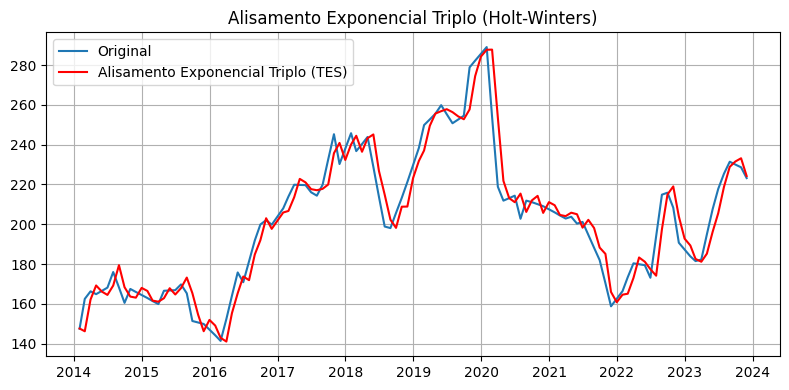

In [21]:
# Definir a frequência das datas no índice aplicando ao dataframe inteiro
prices = prices.asfreq('M')  # Ajuste a frequência conforme seus dados ## Alteração ME para M --Alessandro / Vitinho

# Criando um dataframe para armazenar os valores ajustados
TES = pd.DataFrame(index=prices.index)

serie = prices.Close.interpolate()
# Ajustando o modelo de Alisamento Exponencial Triplo (Holt-Winters)
modelo = ExponentialSmoothing(serie, trend='add', seasonal='add', seasonal_periods=12)
ajuste = modelo.fit(optimized=True)  # Pode tentar ajustando parâmetros aqui se necessário
TES.Close = ajuste.fittedvalues

# Série original e Alisamento Exponencial Triplo
plt.figure(figsize=(8, 4))
plt.plot(serie, label='Original')
plt.plot(TES.Close, label='Alisamento Exponencial Triplo (TES)', color='red')
plt.title(f'Alisamento Exponencial Triplo (Holt-Winters)')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

* Este gráfico apresenta dados para o ativo HGBS11.SA, também mostrando a série original e o alisamento exponencial triplo. Nota-se que:
  * O ativo apresenta uma volatilidade maior comparado ao gráfico superior.
  * Há um pico muito pronunciado em 2020, seguido por uma queda acentuada.
  * O modelo de alisamento captura bem as tendências gerais, suavizando os movimentos mais bruscos.
  * Observa-se uma recuperação após 2022, com outro pico em 2023.
  * A previsão para o futuro próximo sugere uma tendência de queda suave.

* O método de Holt-Winters parece eficaz em capturar as tendências gerais e sazonalidades das séries, fornecendo uma visão suavizada das flutuações do mercado. É importante notar que, embora o modelo ofereça previsões, estas devem ser interpretadas com cautela, considerando outros fatores que podem influenciar o comportamento futuro dos ativos.

### 4.12. Método de média móvel: simples e exponencial

O método de média móvel é indicado para avaliar a tendência da série, mas pela presença de sazonalidade o mais indicado para esse caso é a média móvel
exponencial.

O ativo possui alguns períodos no tempo sem valor (NaN). Vamos gerar média móvel considerando:
  * a remoção de valores nulos;
  * a substituição dos valores nulos pela mediana;

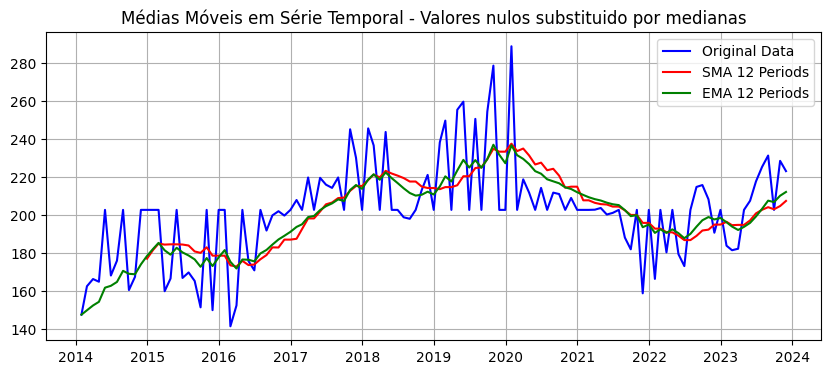

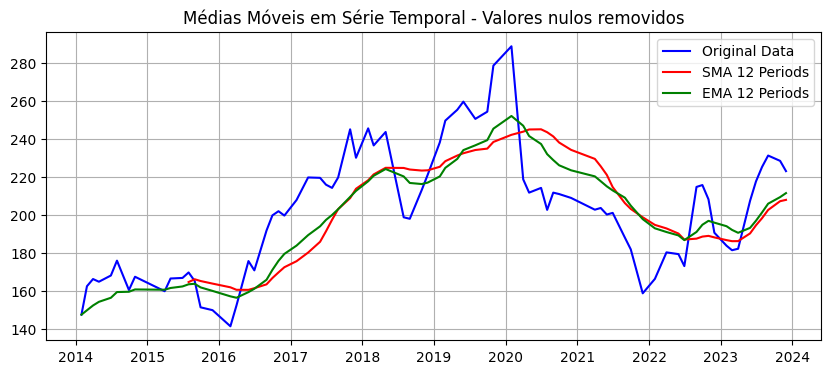

In [22]:
prices_mediana = prices.fillna(prices['Close'].median())

prices_nan = prices.dropna(subset=['Close'])

# Calcular a Média Móvel Simples (SMA)
window_size = 12
for idx, prices in enumerate([prices_mediana, prices_nan]):
  prices['SMA'] = prices['Close'].rolling(window=window_size).mean()

  # Calcular a Média Móvel Exponencial (EMA)
  prices['EMA'] = prices['Close'].ewm(span=window_size, adjust=False).mean()

  # Plotar os resultados
  plt.figure(figsize=(10, 4))
  plt.plot(prices['Close'], label='Original Data', color='blue')
  plt.plot(prices['SMA'], label=f'SMA {window_size} Periods', color='red')
  plt.plot(prices['EMA'], label=f'EMA {window_size} Periods', color='green')
  if idx == 0:
    plt.title('Médias Móveis em Série Temporal - Valores nulos substituido por medianas')
  else:
    plt.title('Médias Móveis em Série Temporal - Valores nulos removidos')
  plt.legend()
  plt.grid()
  plt.show()

A análise da série temporal com a inclusão das médias móveis simples (SMA) e exponencial (EMA) permite entender melhor as tendências e a suavização da série.

**Análise das Médias Móveis:**
- **Média Móvel Simples (SMA - Vermelho):**
  - **Definição:** A SMA é calculada como a média aritmética dos valores de um conjunto de dados ao longo de um período específico (neste caso, 12 períodos).
  - **Observações:**
    - A SMA segue de perto a tendência geral da série temporal, mas devido à sua natureza de média simples, ela tende a ser mais lenta para reagir a mudanças bruscas.
    - No gráfico, a SMA apresenta uma curva mais suavizada, atrasando em relação aos picos e vales da série original (linha azul).
    - A SMA é eficaz para identificar a direção geral da tendência, mas pode não capturar bem as flutuações rápidas.

- **Média Móvel Exponencial (EMA - Verde):**
  - **Definição:** A EMA dá mais peso aos valores mais recentes, o que permite que ela responda mais rapidamente às mudanças na série.
  - **Observações:**
    - A EMA acompanha a série original mais de perto que a SMA, reagindo mais rapidamente a variações abruptas nos dados.
    - Como esperado, a EMA é mais sensível às mudanças do que a SMA, o que a torna mais útil para detectar inversões de tendência e movimentos recentes.
    - No gráfico, a EMA captura as mudanças de tendência um pouco antes da SMA, mostrando-se mais responsiva, especialmente em períodos de alta volatilidade.

**Comparação com a Série Original:**
- **Tendências de Longo Prazo:**
  - Ambas as médias móveis ajudam a destacar a tendência de longo prazo, mas a SMA suaviza mais as flutuações, o que pode ser útil para uma visão mais geral.
  - A EMA, por ser mais responsiva, é útil para detectar mudanças mais rápidas e pode ser preferível em uma análise onde a rapidez de resposta é crucial.

- **Impacto dos Valores Nulos Removidos:**
  - Remover os valores nulos, em vez de substituí-los pela mediana, pode ter impactado a continuidade e a suavidade da série original, o que é visível no comportamento das médias móveis.
  - Ao remover valores nulos, a EMA e a SMA refletem diretamente a série sem as possíveis distorções que poderiam ocorrer se os nulos fossem preenchidos com a mediana.

**Conclusão Geral:**
- **Escolha da Média Móvel:** A escolha entre SMA e EMA depende do objetivo da análise. Se o interesse é capturar rapidamente mudanças de tendência, a EMA pode ser mais apropriada. Para uma visão mais suavizada e de longo prazo, a SMA pode ser melhor.
- **Remoção de Valores Nulos:** A remoção de valores nulos faz com que as médias móveis representem mais fielmente as partes ativas da série temporal, sem introduzir possíveis distorções. Isso é particularmente importante em séries onde os valores nulos podem estar associados a eventos significativos ou falta de dados relevantes.
  
Essa análise proporciona uma compreensão das diferentes técnicas de suavização e como elas podem ser aplicadas para entender melhor a série temporal do ativo HGBS11.SA.

In [26]:
prices.to_excel(r'D:\Github\PUCMinas_DataScience\05-Series_Temporais\Exercícios\Tarefa 3\prices.xlsx')